# Summary of Findings
*Trainset: data before 2024*
1. **Data Quality**: No null values, but latitude and longtitude data are inconsistent with start_station and end_station info.
1. **Routes**: The most popular routes are round trips (primarily near tourist attractions) and campus commutes (need someone more familiar with chicago to confirm). For Round-trip routes, they tend to have a higher number of rides per route.
2. **Yearly Seasonality**: The data exhibits strong yearly seasonality. Winter has smaller mean and vairance. Difference in variance could be an issue in the modelling process.
3. **Weekly Seasonality**: Moderate weekly seasonality could be seen from ACF and PACF. Saturdays see the highest number of rides, but in winter, weekday ridership surpasses weekends.
3. **Trend**: The yearly moving average initially rises (likely due to post-COVID recovery) before gradually slowly declining.




# Preparations

In [2]:
!pip install sktime

In [3]:
import requests
from bs4 import BeautifulSoup
import os
from google.colab import drive
import json
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt
from sktime.performance_metrics.forecasting import mean_absolute_error
from sktime.performance_metrics.forecasting import mean_squared_error, mean_absolute_percentage_error


warnings.filterwarnings("ignore")

In [4]:
# Step 1: Connect to Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
def plot_ts(time_data,plot_data,title_ts=""): # plot 1 time series
  fig, ax = plt.subplots(figsize=(20, 5))

  # Plot the data
  ax.plot(time_data,plot_data)

  # Set the primary x-axis for months
  ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%m'))

  # Add the secondary x-axis for years in the middle of the year
  sec_ax = ax.secondary_xaxis("bottom")
  sec_ax.xaxis.set_major_locator(mdates.YearLocator())
  sec_ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
  sec_ax.tick_params(axis='x', which='major', pad=20)

  # Labeling and title
  ax.set_ylabel('Number of Rides')
  ax.set_title(title_ts)
  sec_ax.set_xlabel('Time')

  # Display the grid and the plot
  ax.grid(True)
  plt.show()

def compare_ts(time_data, series1, series2, label1, label2, title_ts="", same_scale=False):
    fig, ax1 = plt.subplots(figsize=(20, 5))

    # Plot series1 on the left y-axis
    line1, = ax1.plot(time_data, series1, color='blue', label=label1)
    ax1.set_ylabel(label1, color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Set the primary x-axis for months
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m'))

    # Add the secondary x-axis for years
    sec_ax = ax1.secondary_xaxis("bottom")
    sec_ax.xaxis.set_major_locator(mdates.YearLocator())
    sec_ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    sec_ax.tick_params(axis='x', which='major', pad=20)
    sec_ax.set_xlabel('Time')

    # Create a twin axis for the right y-axis
    ax2 = ax1.twinx()
    line2, = ax2.plot(time_data, series2, color='orange', label=label2)
    ax2.set_ylabel(label2, color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    # Set the same y-axis scale if same_scale is True
    if same_scale:
        min_val = min(series1.min(), series2.min())
        max_val = max(series1.max(), series2.max())
        ax1.set_ylim(min_val, max_val)
        ax2.set_ylim(min_val, max_val)

    # Set title and grid
    ax1.set_title(title_ts)
    ax1.grid(True)

    # Combine legends for both plots
    lines = [line1, line2]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc="upper left")

    # Adjust layout
    fig.tight_layout()
    plt.show()

def error_metrics(real, pred): # Compare predictions and real values
  mae = mean_absolute_error(real, pred)
  mse = mean_squared_error(real, pred)
  mape = mean_absolute_percentage_error(real, pred)
  smape = mean_absolute_percentage_error(real, pred, symmetric=True)
  r2 = r2_score(real, pred)  # Calculate R-squared

  # Print results
  print(f"Mean Absolute Error (MAE): {mae:.2f}")
  print(f"Mean Squared Error (MSE): {mse:.2f}")
  print(f"Mean Absolute Percentage Error (MAPE): {mape*100:.2f}%")
  print(f"Symmetric Mean Absolute Percentage Error (sMAPE): {smape*100:.2f}%")
  print(f"R-squared (R²): {r2:.4f}")  # Display R-squared

# Train Test Split

In [6]:
data_raw = pd.read_parquet("/content/drive/Shared drives/Time Series/divvy_data/prod/divvy_data_expanded.parquet")
print(data_raw.shape)
data_raw.head(4)

(21846092, 12)


,rideable_type,date,start_station_name,end_station_name,start_station_id,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,rides
0,classic_bike,2020-12-02,900 W Harrison St,Wolcott Ave & Polk St,13028,TA1309000064,41.874754,-87.649807,41.871262,-87.673688,member,1
1,classic_bike,2020-12-02,Aberdeen St & Jackson Blvd,Clinton St & Roosevelt Rd,13157,WL-008,41.877726,-87.654787,41.867118,-87.641088,member,1
2,classic_bike,2020-12-02,Albany Ave & Montrose Ave,Kedzie Ave & Milwaukee Ave,15621,13085,41.961041,-87.705866,41.929567,-87.707857,member,1
3,classic_bike,2020-12-02,Ashland Ave & 13th St,Blue Island Ave & 18th St,13354,13135,41.865234,-87.666507,41.857556,-87.661535,member,1


In [7]:
data_raw["date"] = pd.to_datetime(data_raw["date"])
data_raw.sort_values("date",inplace=True)
data_raw["month"] = data_raw["date"].dt.month
data_raw["dayofweek"] = data_raw["date"].dt.dayofweek
data_raw["year"] = data_raw["date"].dt.year

In [8]:
data = data_raw[data_raw["date"]<"2024-01-01"]
data.tail()

,rideable_type,date,start_station_name,end_station_name,start_station_id,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,rides,month,dayofweek,year
14196090,classic_bike,2023-12-31,Clark St & Armitage Ave,Sheffield Ave & Webster Ave,13146,TA1309000033,41.918306,-87.636282,41.921540,-87.653818,member,1,12,6,2023
14196089,classic_bike,2023-12-31,Clark St & Armitage Ave,Larrabee St & Webster Ave,13146,13193,41.918306,-87.636282,41.921822,-87.644140,member,1,12,6,2023
14196088,classic_bike,2023-12-31,Clark St & Armitage Ave,Lakeview Ave & Fullerton Pkwy,13146,TA1309000019,41.918306,-87.636282,41.925858,-87.638973,casual,1,12,6,2023
14196087,classic_bike,2023-12-31,Clarendon Ave & Leland Ave,Michigan Ave & Pearson St,TA1307000119,13034,41.967968,-87.650001,41.897660,-87.623510,casual,1,12,6,2023
14196086,classic_bike,2023-12-31,Clarendon Ave & Junior Ter,Pine Grove Ave & Waveland Ave,13389,TA1307000150,41.961004,-87.649603,41.949473,-87.646453,member,1,12,6,2023


In [9]:
testset = data_raw[data_raw["date"]>="2024-01-01"]
testset.head()

,rideable_type,date,start_station_name,end_station_name,start_station_id,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,rides,month,dayofweek,year
19127624,electric_bike,2024-01-01,Outside of Dock,Outside of Dock,,,41.94,-87.68,41.95,-87.69,casual,1,1,0,2024
19127619,electric_bike,2024-01-01,Outside of Dock,Outside of Dock,,,41.93,-87.64,41.93,-87.65,casual,1,1,0,2024
19127623,electric_bike,2024-01-01,Outside of Dock,Outside of Dock,,,41.94,-87.68,41.94,-87.68,member,1,1,0,2024
19127626,electric_bike,2024-01-01,Outside of Dock,Outside of Dock,,,41.94,-87.67,41.94,-87.68,casual,1,1,0,2024
19127622,electric_bike,2024-01-01,Outside of Dock,Outside of Dock,,,41.94,-87.70,41.93,-87.69,member,1,1,0,2024


In [10]:
rides_by_date = data.groupby(["date","month","dayofweek","year"])["rides"].sum().reset_index()
rides_by_date.head()

,date,month,dayofweek,year,rides
0,2020-01-01,1,2,2020,2141
1,2020-01-02,1,3,2020,6479
2,2020-01-03,1,4,2020,5890
3,2020-01-04,1,5,2020,3187
4,2020-01-05,1,6,2020,3035


In [11]:
data.isnull().sum()

,0
rideable_type,0
date,0
start_station_name,0
end_station_name,0
start_station_id,0
end_station_id,0
start_lat,0
start_lng,0
end_lat,0
end_lng,0


# Number of rides throught time

## Daily Data

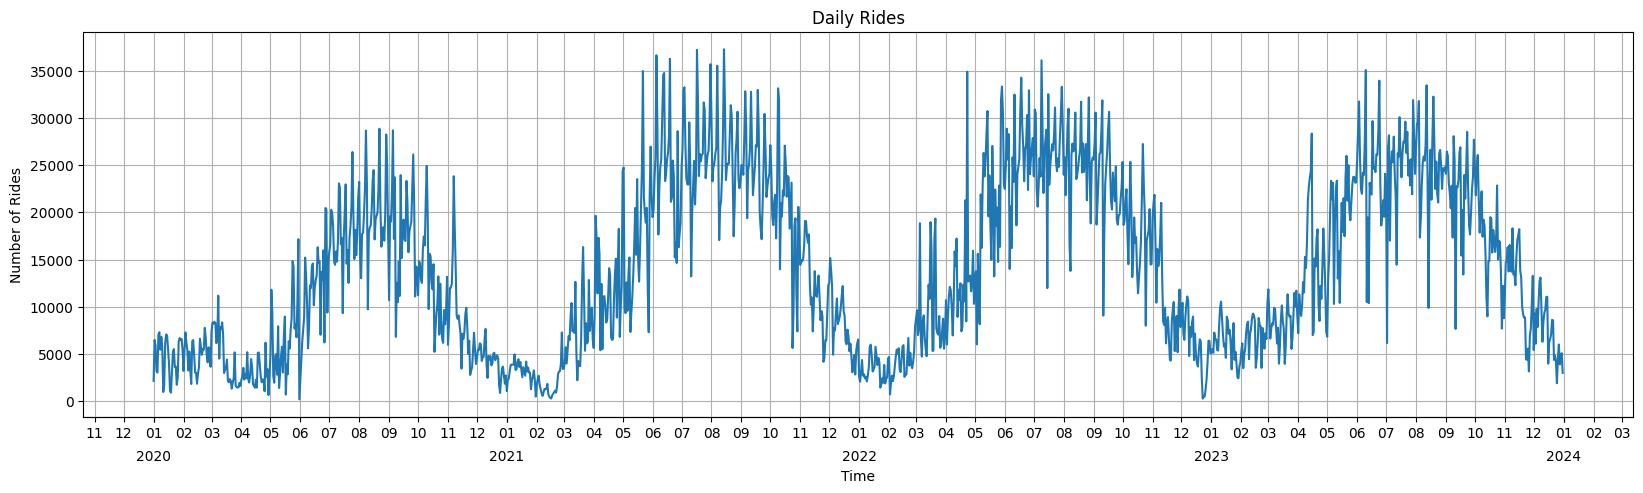

In [12]:
plot_ts(rides_by_date['date'], rides_by_date['rides'],"Daily Rides")

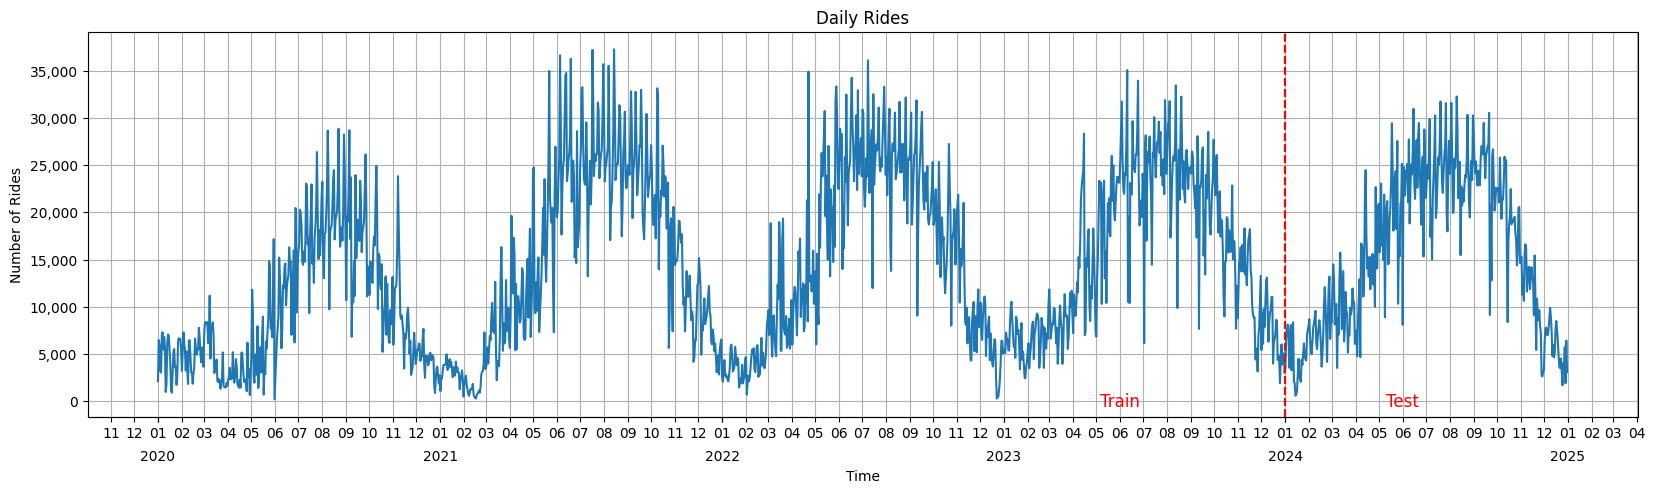

In [13]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
rides_by_date_n = data_raw.groupby(["date","month","dayofweek","year"])["rides"].sum().reset_index()
time_data = rides_by_date_n['date']
plot_data = rides_by_date_n['rides']
title_ts = "Daily Rides"
fig, ax = plt.subplots(figsize=(20, 5))
ax.axvline(pd.to_datetime('2024-01-01'), color='red', linestyle='--')

# Add text for train and test
ax.text(pd.to_datetime('2023-06-01'), ax.get_ylim()[1] * 0.9, 'Train', color='red', ha='center', va='center', fontsize=12)  # Adjust position as needed
ax.text(pd.to_datetime('2024-06-01'), ax.get_ylim()[1] * 0.9, 'Test', color='red', ha='center', va='center', fontsize=12)  # Adjust position as needed

# Plot the data
ax.plot(time_data, plot_data)

# Set the primary x-axis for months
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m'))

# Add the secondary x-axis for years in the middle of the year
sec_ax = ax.secondary_xaxis("bottom")
sec_ax.xaxis.set_major_locator(mdates.YearLocator())
sec_ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
sec_ax.tick_params(axis='x', which='major', pad=20)

# Add a vertical line at 2024-01-01
ax.axvline(pd.to_datetime('2024-01-01'), color='red', linestyle='--')

# Labeling and title
ax.set_ylabel('Number of Rides')
ax.set_title(title_ts)
sec_ax.set_xlabel('Time')


# Format y-axis labels with commas
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))



# Display the grid and the plot
ax.grid(True)
plt.show()

Peaks at July-Sep, bottom at Jan-March.

## Monthly Moving Average

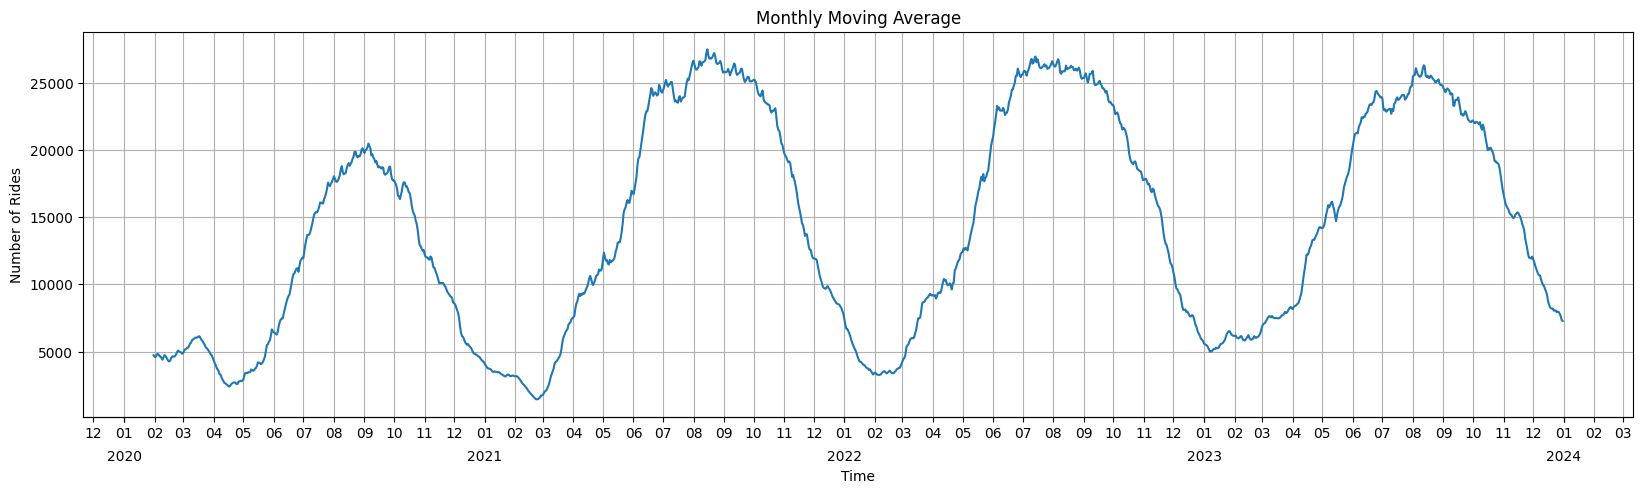

In [14]:
rides_by_date["monthly_moving_avg"] = rides_by_date["rides"].rolling(window=30, min_periods=1).mean()
plot_ts(rides_by_date['date'][30:], rides_by_date["monthly_moving_avg"][30:],"Monthly Moving Average")

## Yearly Moving Average

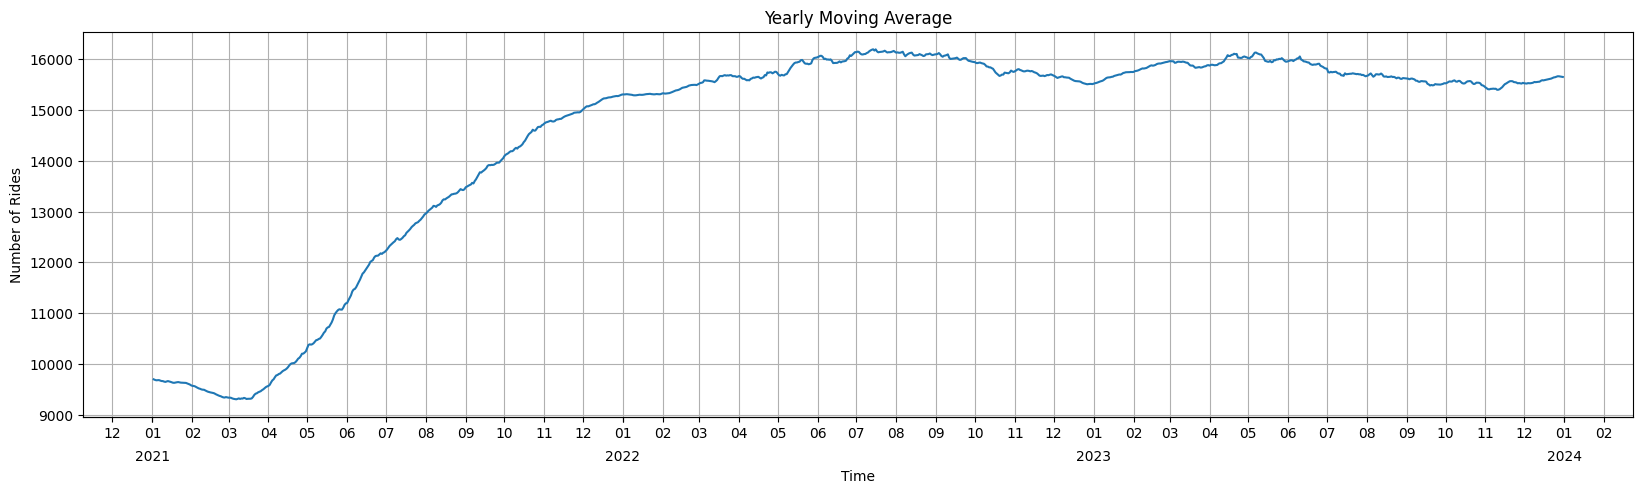

In [15]:
rides_by_date["yearly_moving_avg"] = rides_by_date["rides"].rolling(window=365, min_periods=1).mean()
plot_ts(rides_by_date['date'][365:], rides_by_date["yearly_moving_avg"][365:],"Yearly Moving Average")


Yearly average level first increase (possibly due to the recovering of covid), then level.

# Bike Type

## Total Distribution

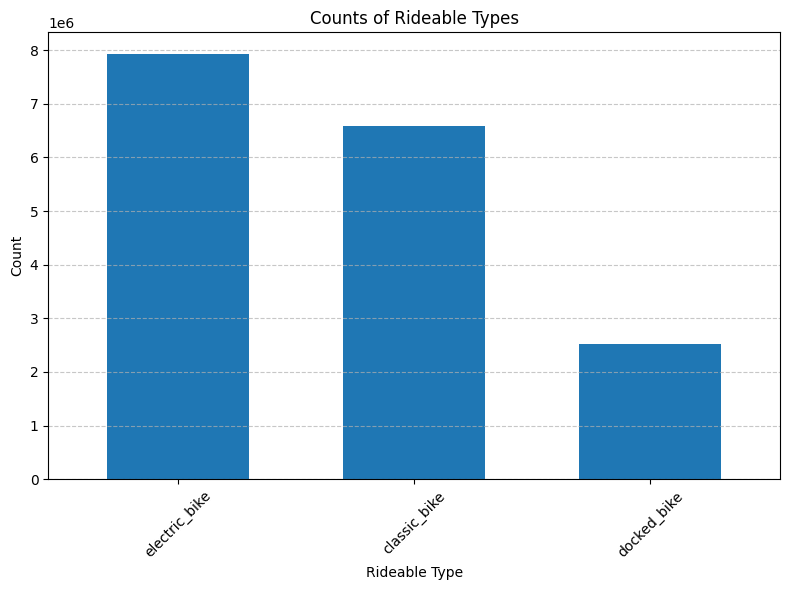

In [16]:
rideable_type_counts = data.rideable_type.value_counts()

# Plotting the bar chart
plt.figure(figsize=(8, 6))
rideable_type_counts.plot(kind='bar', width=0.6)
plt.title('Counts of Rideable Types')
plt.xlabel('Rideable Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Proportion through time

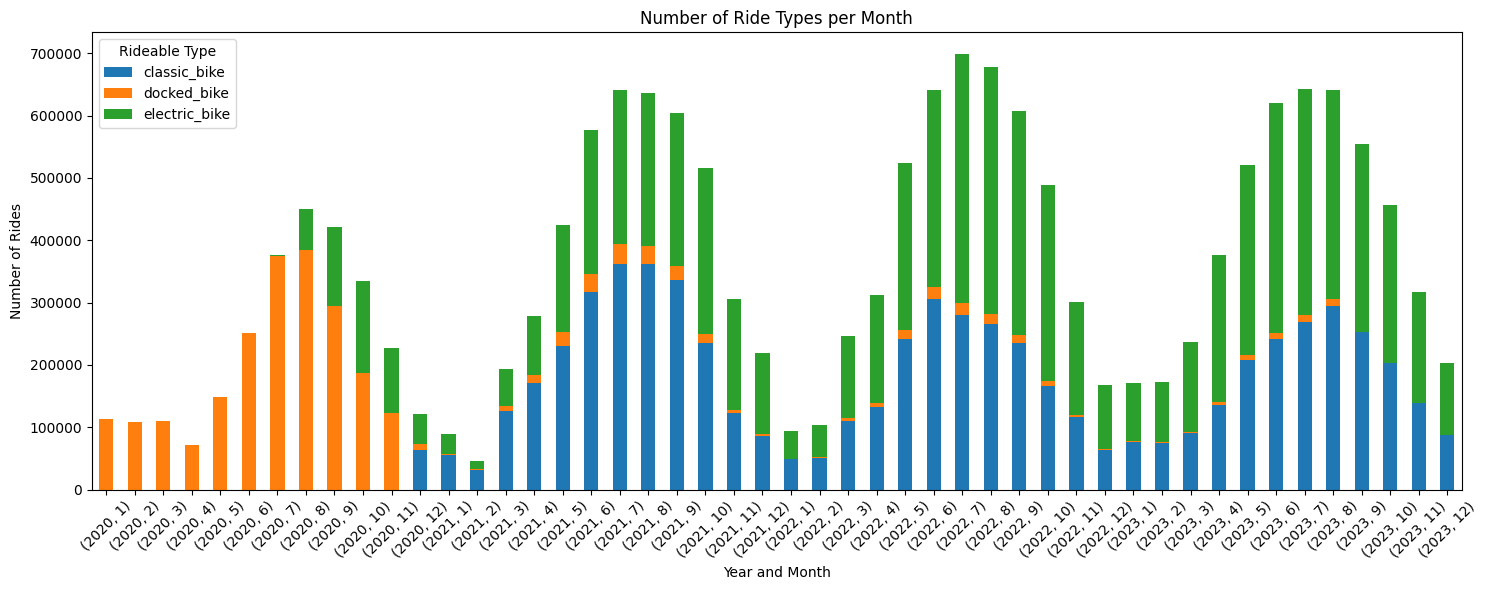

In [17]:
# stacked bar of number of ride type through the whole time range(monthly)
ride_type_counts = data.groupby(["year", 'month', 'rideable_type'])['rideable_type'].count().unstack()
ride_type_counts.plot(kind='bar', stacked=True, figsize=(15, 6))
plt.title('Number of Ride Types per Month')
plt.xlabel('Year and Month')
plt.ylabel('Number of Rides')
plt.xticks(rotation=45)
plt.legend(title='Rideable Type')
plt.tight_layout()
plt.show()

July 29, 2020 is the date when divvy introduced electric bike, as can be proved by the plot.

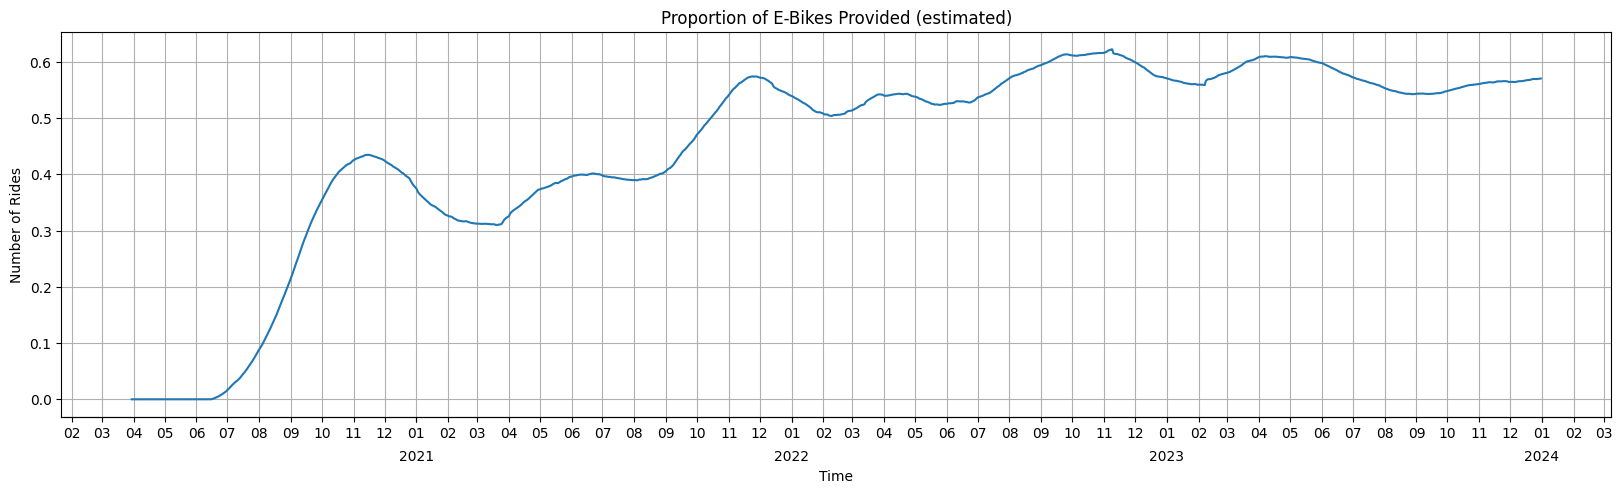

In [18]:
# prompt: # proportion of ebikes in the moving window

# Calculate the proportion of e-bikes in a moving window
window_size = 30*3  # Example window size (you can adjust this)

rides_by_date['ebike_proportion'] = (
    data.groupby('date')['rideable_type']
    .apply(lambda x: (x == 'electric_bike').sum() / len(x))
    .rolling(window=window_size, min_periods=1, center=True)  # Center the window
    .mean()
    .reset_index(drop=True)
    .shift(1)  # Shift the result by one position
)

# Plot the e-bike proportion over time
plot_ts(rides_by_date['date'][window_size-1:], rides_by_date['ebike_proportion'][window_size-1:],
        "Proportion of E-Bikes Provided (estimated)")
# estimated using moving window that span the past 3 months
# You can adjust the window size and explore other moving window functions like rolling().sum()
# or rolling().std() as needed.


# Docked vs Outside of dock

In [19]:
data["docked_outside_start"]=(data["start_station_name"]=="Outside of Dock")
tmp=data["docked_outside_start"].value_counts().reset_index()
tmp["percent"]=tmp["count"]/tmp["count"].sum()
tmp

,docked_outside_start,count,percent
0,False,14966725,0.878339
1,True,2073071,0.121661


In [20]:
data[data["docked_outside_start"]==True].rideable_type.value_counts()

,count
rideable_type,
electric_bike,2073071


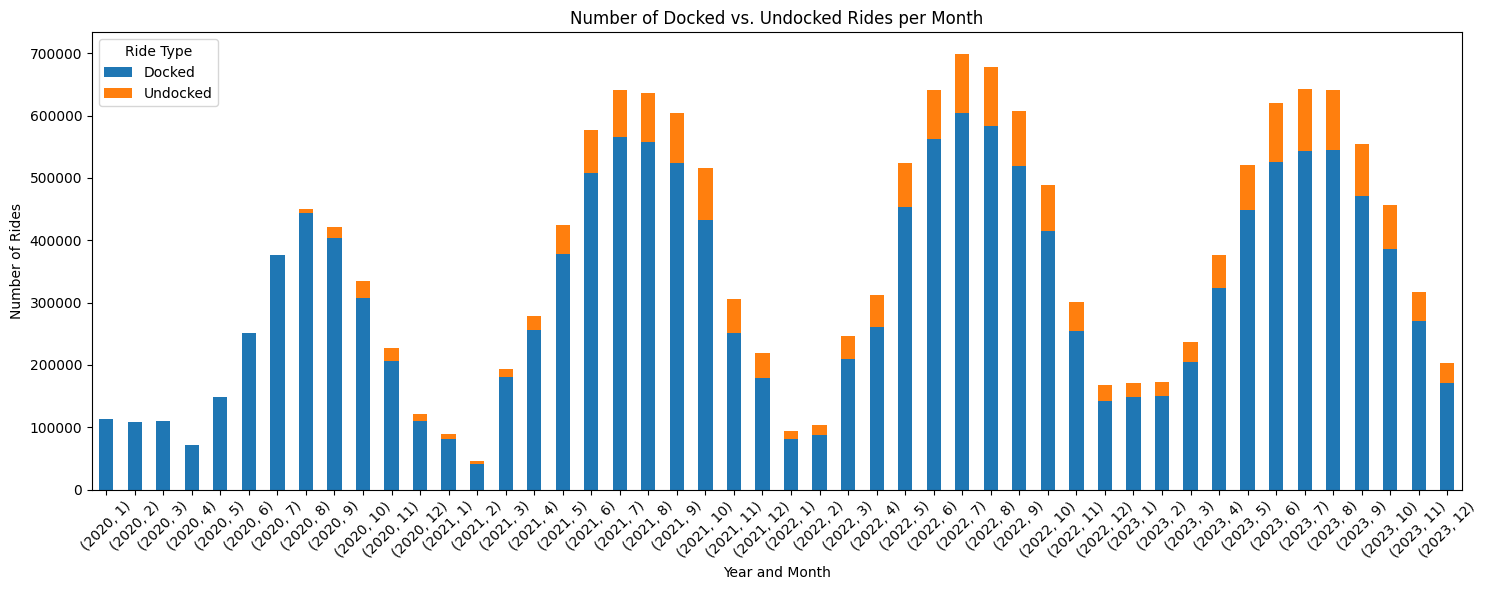

In [21]:
# Plot the stacked bar chart
data["docked_outside_start"] = (data["start_station_name"] == "Outside of Dock")

# Group by year, month, and docked_outside status, then count
docked_undocked_counts = data.groupby(["year", 'month', 'docked_outside_start'])['docked_outside_start'].count().unstack()

# Rename columns for clarity
docked_undocked_counts.columns = ['Docked', 'Undocked']
docked_undocked_counts.plot(kind='bar', stacked=True, figsize=(15, 6))
plt.title('Number of Docked vs. Undocked Rides per Month')
plt.xlabel('Year and Month')
plt.ylabel('Number of Rides')
plt.xticks(rotation=45)
plt.legend(title='Ride Type')
plt.tight_layout()
plt.show()

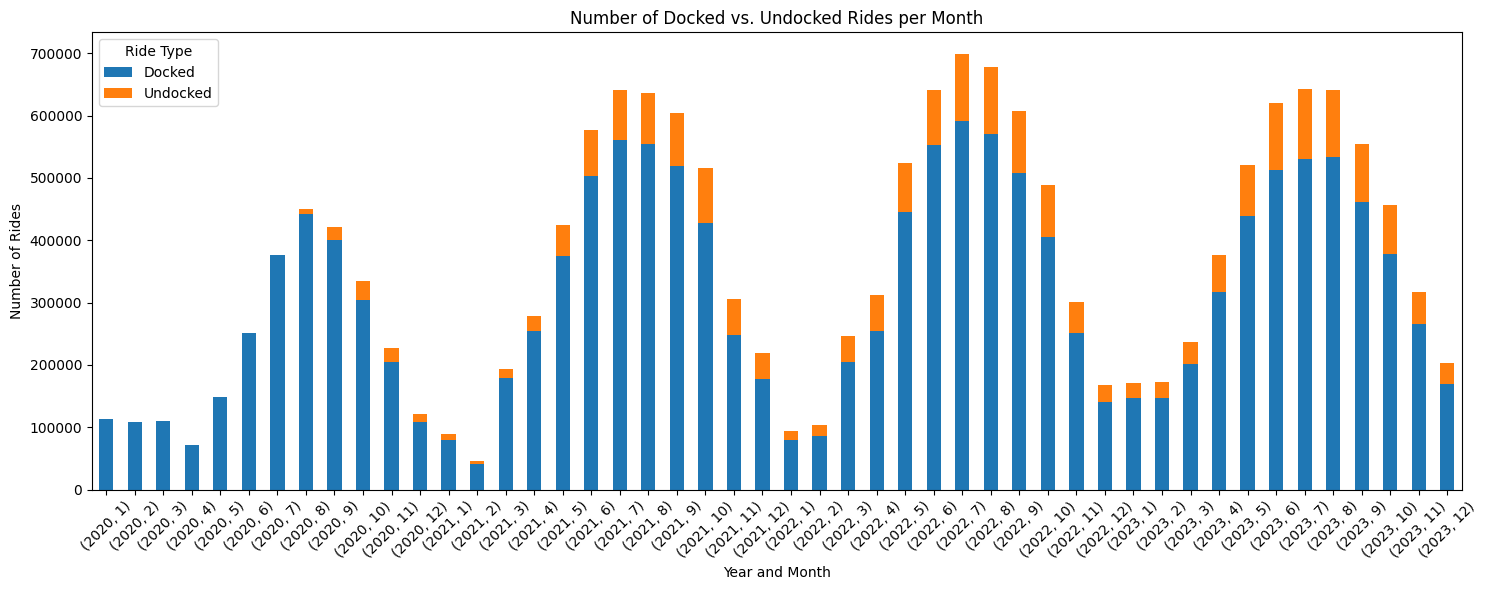

In [22]:
# Plot the stacked bar chart
data["docked_outside_end"] = (data["end_station_name"] == "Outside of Dock")

# Group by year, month, and docked_outside status, then count
docked_undocked_counts = data.groupby(["year", 'month', 'docked_outside_end'])['docked_outside_end'].count().unstack()

# Rename columns for clarity
docked_undocked_counts.columns = ['Docked', 'Undocked']
docked_undocked_counts.plot(kind='bar', stacked=True, figsize=(15, 6))
plt.title('Number of Docked vs. Undocked Rides per Month')
plt.xlabel('Year and Month')
plt.ylabel('Number of Rides')
plt.xticks(rotation=45)
plt.legend(title='Ride Type')
plt.tight_layout()
plt.show()

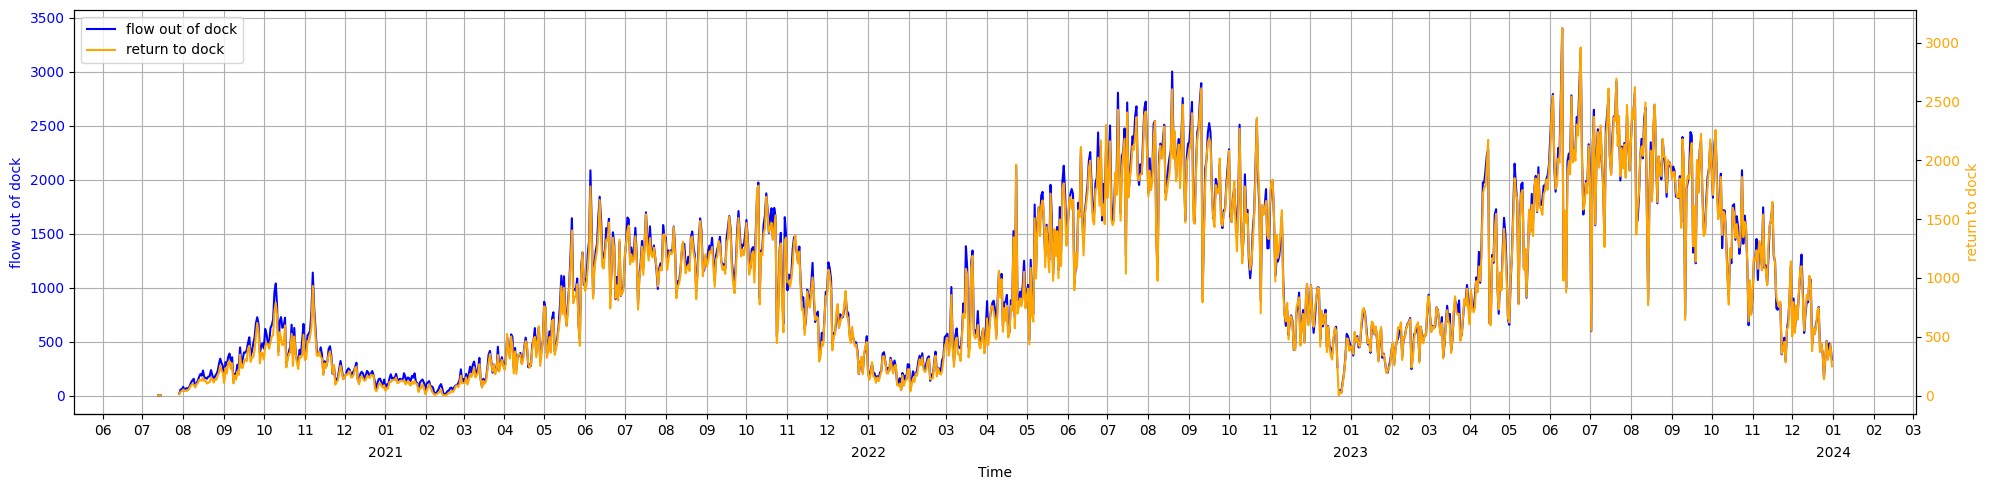

In [23]:
trip_counts = data.groupby(["date", 'docked_outside_end',"docked_outside_start"])['rides'].sum().reset_index()
trip_counts["docked_undocked"]=""
trip_counts["docked_undocked"][(trip_counts["docked_outside_start"]==True) & (trip_counts["docked_outside_end"]==False)]="return"
trip_counts["docked_undocked"][(trip_counts["docked_outside_start"]==False) & (trip_counts["docked_outside_end"]==True)]="flow out"
trip_counts["docked_undocked"][(trip_counts["docked_outside_start"]==True) & (trip_counts["docked_outside_end"]==True)]="stay out"
trip_counts["docked_undocked"][(trip_counts["docked_outside_start"]==False) & (trip_counts["docked_outside_end"]==False)]="stay in dock"
trip_counts = trip_counts.groupby(["date","docked_undocked"])["rides"].sum().reset_index()

tmp = trip_counts.pivot(index="date", columns="docked_undocked", values="rides").reset_index()
compare_ts(tmp['date'],tmp['flow out'],tmp['return'],"flow out of dock","return to dock")

All of the undocked bikes are electrical and have consistent amount through time.

# Data Quality Concern for Location Data

In [25]:
data["location_unchanged"]= (data["start_lat"]==data["end_lat"]) & (data["start_lng"]==data["end_lng"])
data["round_trip"]=(data['start_station_name']==data['end_station_name'])
data[["docked_outside","location_unchanged"]].value_counts().reset_index()

KeyError: "['docked_outside'] not in index"

In [ ]:
data[["round_trip","location_unchanged"]].value_counts().reset_index()

In [ ]:
data[(data["docked_outside"]==True) & (data["location_unchanged"]==True)].head()

In [ ]:
data[(data["round_trip"]==False) & (data["location_unchanged"]==True)].head()

In [ ]:
data[(data["round_trip"]==True) & (data["location_unchanged"]==False)].head()

This lat and lng data may not be accurate.

# Station & Route

In [ ]:
route_count = data.groupby(["start_station_name","end_station_name"])["rides"].sum().reset_index().sort_values("rides",ascending=False)

In [ ]:
route_count["round_trip"]=(route_count['start_station_name']==route_count['end_station_name'])


## Top Routes

In [ ]:
route_count.head(20)

,start_station_name,end_station_name,rides,round_trip
181775,Outside of Dock,Outside of Dock,1321856,True
235564,Streeter Dr & Grand Ave,Streeter Dr & Grand Ave,41954,True
162364,Michigan Ave & Oak St,Michigan Ave & Oak St,21498,True
165314,Millennium Park,Millennium Park,19688,True
88216,Ellis Ave & 60th St,Ellis Ave & 55th St,19577,False
82397,DuSable Lake Shore Dr & Monroe St,DuSable Lake Shore Dr & Monroe St,18414,True
88367,Ellis Ave & 60th St,University Ave & 57th St,18073,False
87669,Ellis Ave & 55th St,Ellis Ave & 60th St,17798,False
239063,University Ave & 57th St,Ellis Ave & 60th St,16901,False
82691,DuSable Lake Shore Dr & Monroe St,Streeter Dr & Grand Ave,13683,False


Not round trip routes

In [ ]:
route_count[route_count["round_trip"]==False].head(20)

,start_station_name,end_station_name,rides,round_trip
88216,Ellis Ave & 60th St,Ellis Ave & 55th St,19577,False
88367,Ellis Ave & 60th St,University Ave & 57th St,18073,False
87669,Ellis Ave & 55th St,Ellis Ave & 60th St,17798,False
239063,University Ave & 57th St,Ellis Ave & 60th St,16901,False
82691,DuSable Lake Shore Dr & Monroe St,Streeter Dr & Grand Ave,13683,False
31943,Calumet Ave & 33rd St,State St & 33rd St,11801,False
228188,State St & 33rd St,Calumet Ave & 33rd St,11689,False
235419,Streeter Dr & Grand Ave,Millennium Park,10002,False
151251,Loomis St & Lexington St,Morgan St & Polk St,9591,False
235452,Streeter Dr & Grand Ave,Outside of Dock,9555,False


## Round Trips

In [ ]:
tmp = route_count.groupby("round_trip")["rides"].agg(['sum', 'count']).reset_index()
tmp["trip_per_route"]=tmp["sum"]/tmp["count"]
tmp["percent"]=tmp["count"]/tmp["count"].sum()
tmp

,round_trip,sum,count,trip_per_route,percent
0,False,17910593,267139,67.045969,0.994035
1,True,2586332,1603,1613.432314,0.005965


Types of routes observed:
1. Round Trips: Riders start and end at the same location (e.g., from Millennium Park to Millennium Park). Mostly tourists?
2. Local Campus Rides: Like Short trips near UChicago, connecting nearby streets (e.g., from Ellis Ave & 55th St to Ellis Ave & 60th St).

# Membership

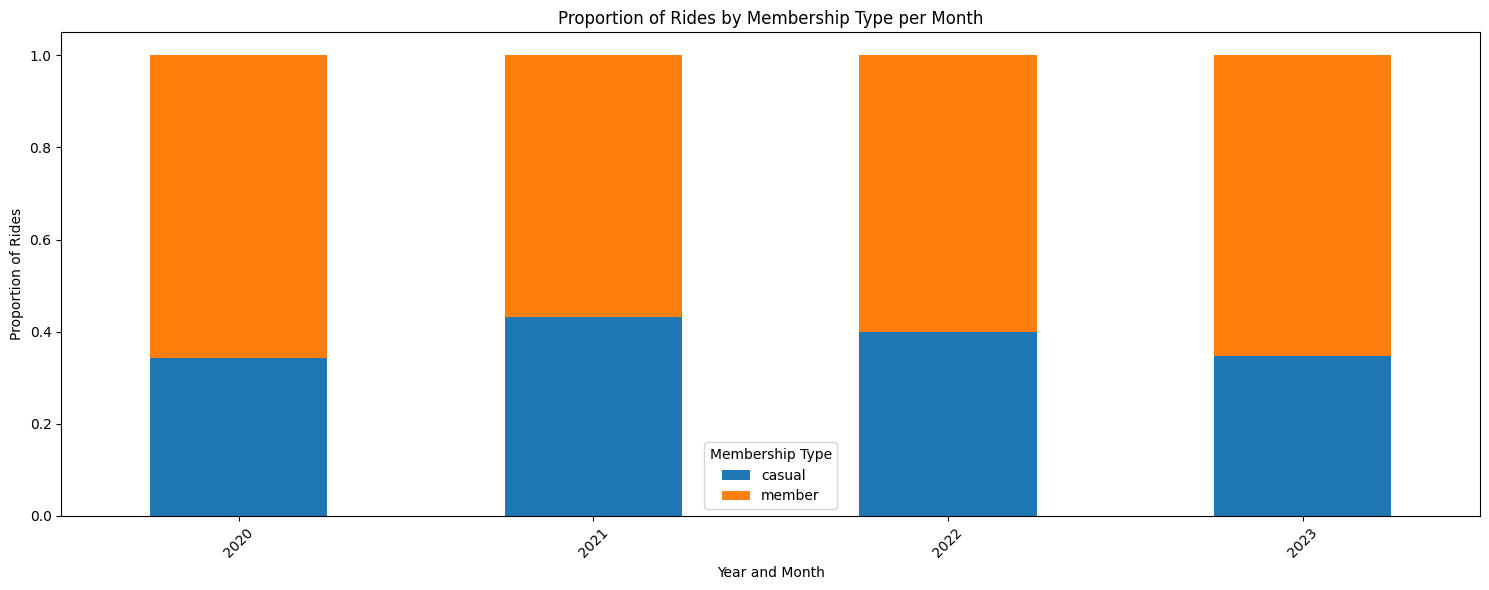

In [ ]:
membership_counts = data.groupby(["year", 'member_casual'])['member_casual'].count().unstack()

# Calculate proportions
membership_proportions = membership_counts.div(membership_counts.sum(axis=1), axis=0)

# Plotting the stacked bar chart
membership_proportions.plot(kind='bar', stacked=True, figsize=(15, 6))
plt.title('Proportion of Rides by Membership Type per Month')
plt.xlabel('Year and Month')
plt.ylabel('Proportion of Rides')
plt.xticks(rotation=45)
plt.legend(title='Membership Type')
plt.tight_layout()
plt.show()

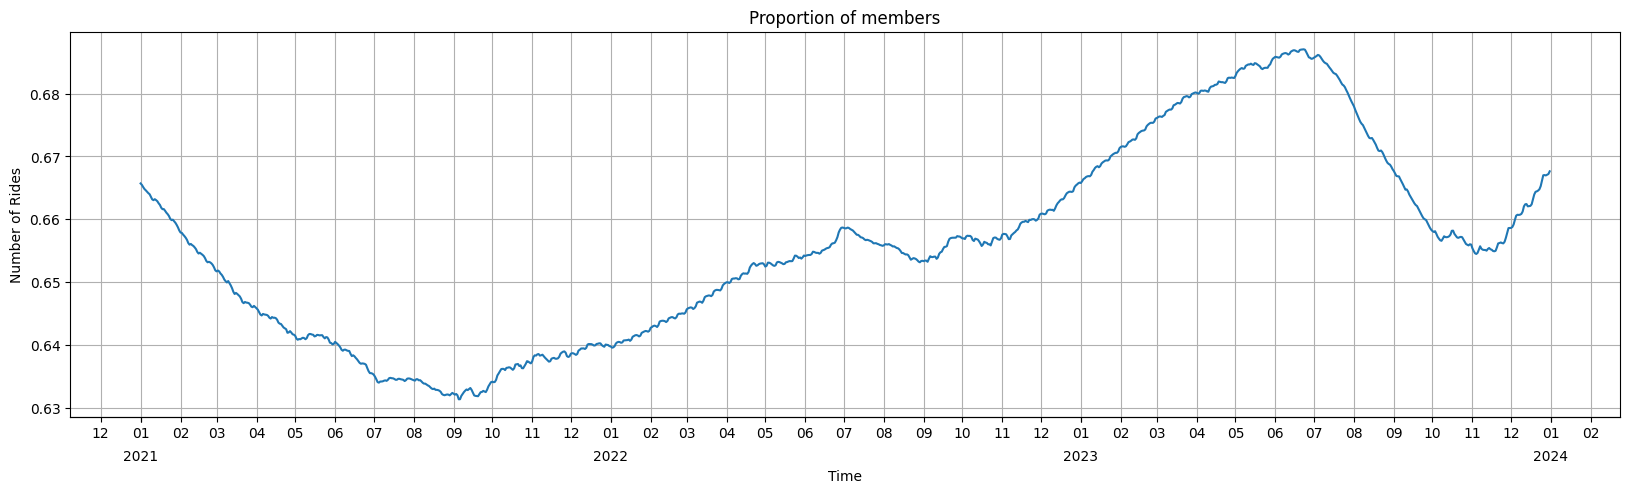

In [ ]:
# prompt: # proportion of ebikes in the moving window

# Calculate the proportion of e-bikes in a moving window
window_size = 365  # Example window size (you can adjust this)

rides_by_date['membership_proportion'] = (
    data.groupby('date')['member_casual']
    .apply(lambda x: (x == 'member').sum() / len(x))
    .rolling(window=window_size, min_periods=1, center=True)  # Center the window
    .mean()
    .reset_index(drop=True)
    .shift(1)  # Shift the result by one position
)

# Plot the e-bike proportion over time
plot_ts(rides_by_date['date'][window_size-1:], rides_by_date['membership_proportion'][window_size-1:],
        "Proportion of members")
# estimated using moving window that span the past 3 months
# You can adjust the window size and explore other moving window functions like rolling().sum()
# or rolling().std() as needed.


More membership usage in winter.

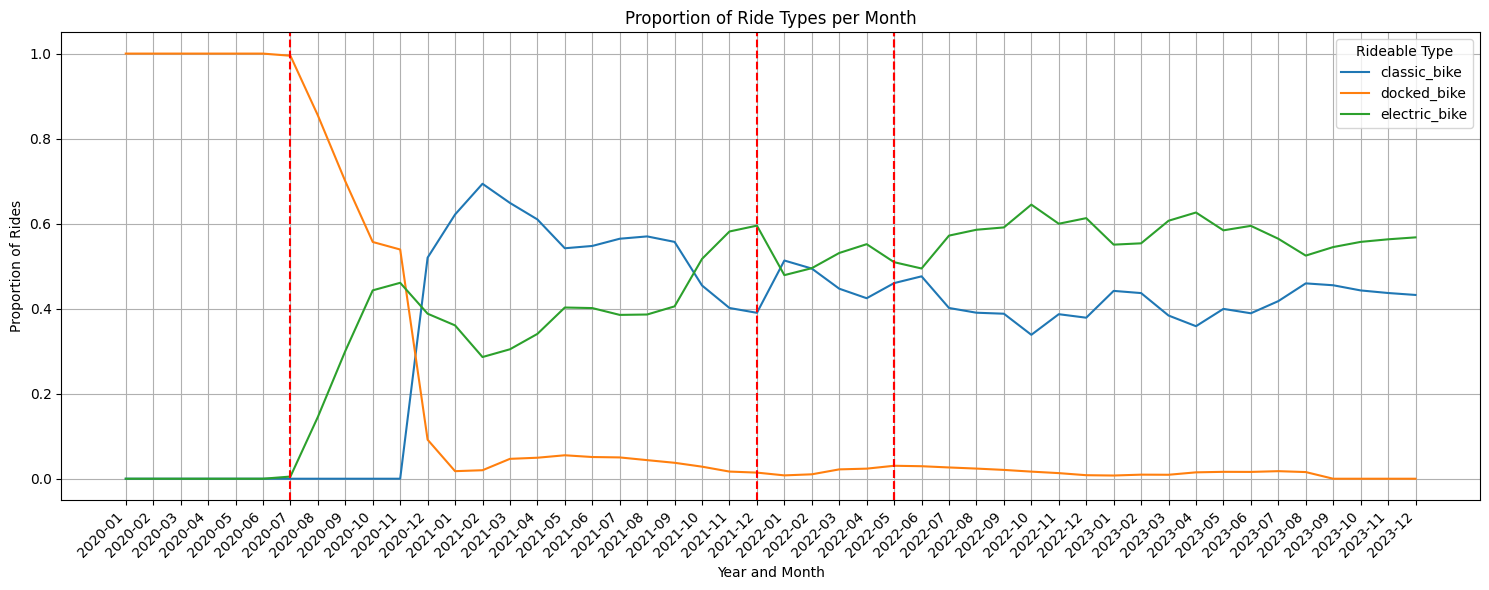

In [ ]:
ride_type_proportions = data.groupby(["year", 'month', 'rideable_type'])['rideable_type'].count().unstack(fill_value=0)
ride_type_proportions = ride_type_proportions.div(ride_type_proportions.sum(axis=1), axis=0)

ride_type_proportions.plot(kind='line', figsize=(15, 6))
plt.title('Proportion of Ride Types per Month')
plt.xlabel('Year and Month')
plt.ylabel('Proportion of Rides')

# Create a list of month labels
months = [f"{year}-{month:02d}" for year in ride_type_proportions.index.get_level_values('year').unique() for month in range(1, 13)]

# Set x-ticks to display all months
plt.xticks(range(len(months)), months, rotation=45, ha='right')

# Mark specific dates
dates_to_mark = pd.to_datetime(['2022-05-10', '2020-07-29', '2021-12-01', '2022-05-01'])

for date in dates_to_mark:
  year = date.year
  month = date.month
  index = (ride_type_proportions.index.get_level_values('year') == year) & (ride_type_proportions.index.get_level_values('month') == month)
  if index.any():
    plt.axvline(x=np.where((ride_type_proportions.index.get_level_values('year') == year) & (ride_type_proportions.index.get_level_values('month') == month))[0][0], color='red', linestyle='--')

plt.legend(title='Rideable Type')
plt.tight_layout()
plt.grid()
plt.show()


In 2021-12, divvy introduced a new e-bike model and in 2022-05, e-bike charging was incorporated.

# Seasonality

### Yearly

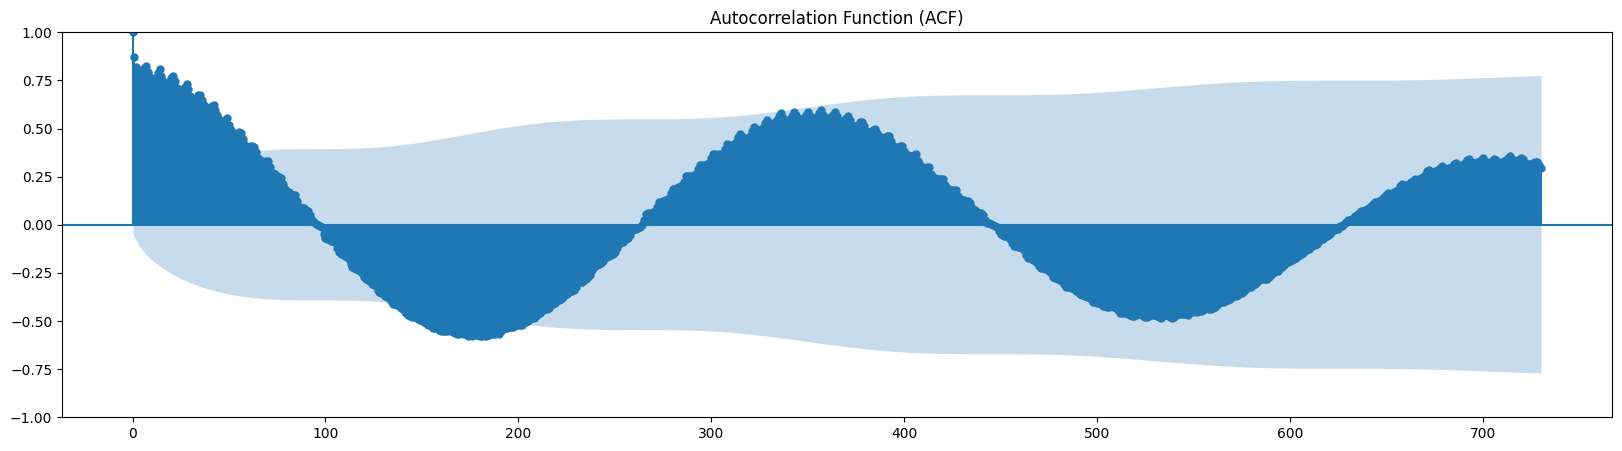

In [ ]:
# Create a figure with the desired figsize for ACF
fig_acf, ax_acf = plt.subplots(figsize=(20, 5))
plot_acf(rides_by_date['rides'], lags=365*2, ax=ax_acf, title='Autocorrelation Function (ACF)')
plt.show()

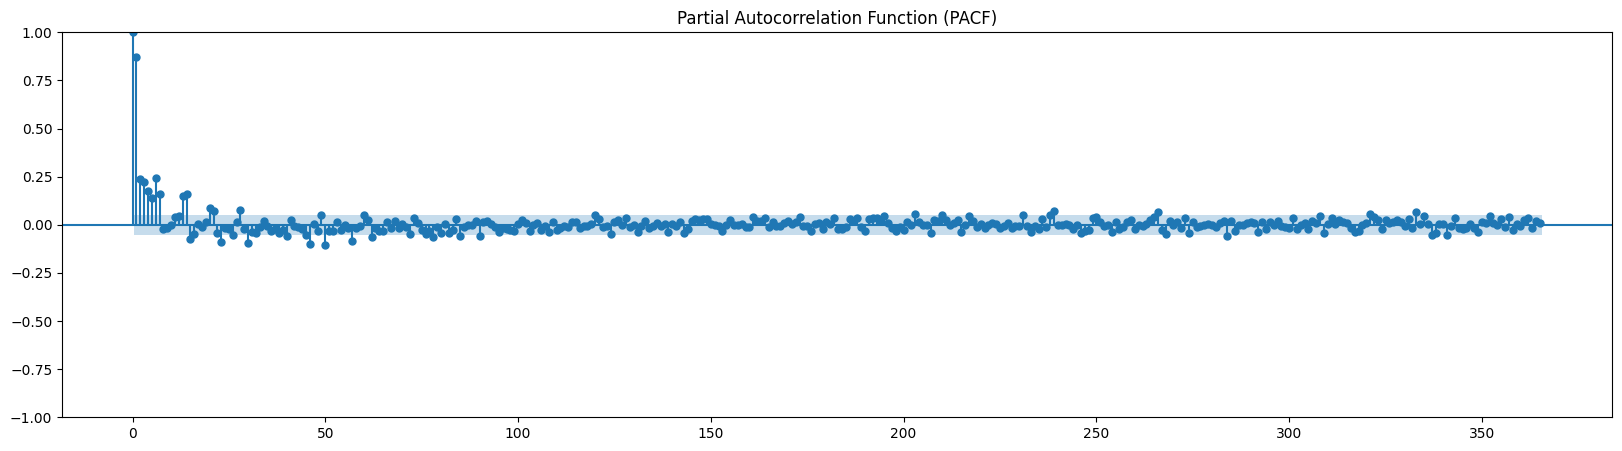

In [ ]:
fig_acf, ax_acf = plt.subplots(figsize=(20, 5))
plot_pacf(rides_by_date['rides'], lags=365, ax=ax_acf, title='Partial Autocorrelation Function (PACF)')
plt.show()

### Weekly

### Day of Week

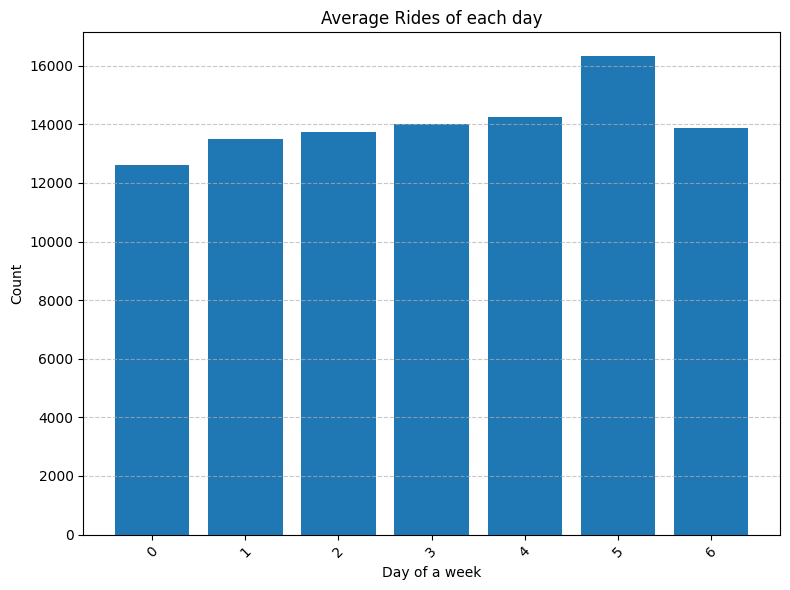

In [ ]:
# Plotting the bar chart
plt.figure(figsize=(8, 6))
tmp = rides_by_date.groupby("dayofweek")["rides"].mean().reset_index()
plt.bar(tmp["dayofweek"],tmp["rides"])
plt.title('Average Rides of each day')
plt.xlabel('Day of a week')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Saturday seems to have the highest volumn, which proves that our core usage could be tourism.

Day of week

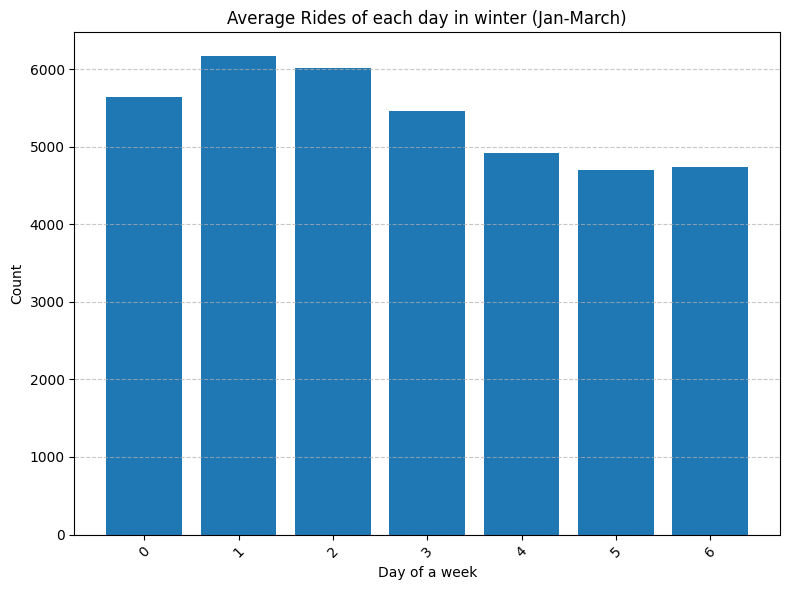

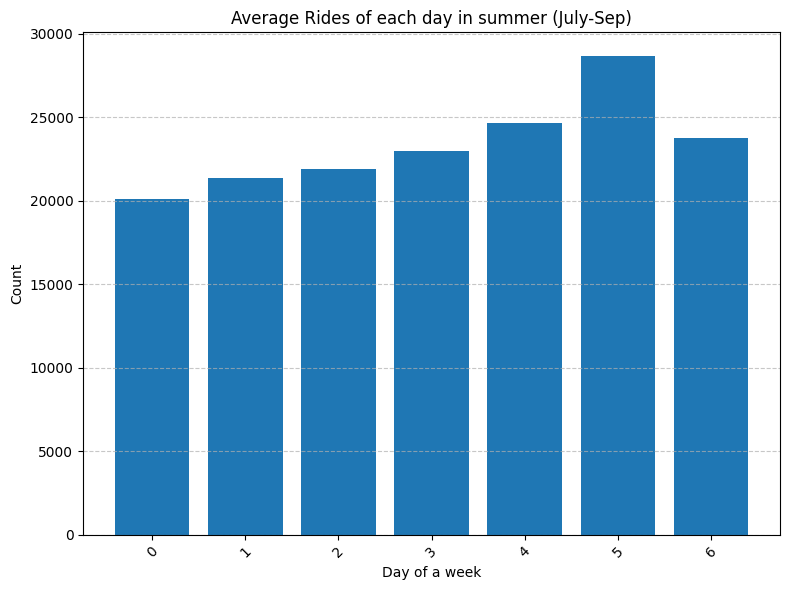

In [ ]:
# Plotting the bar chart
plt.figure(figsize=(8, 6))
tmp = rides_by_date[(rides_by_date["month"]>=1) & (rides_by_date["month"]<=3)].groupby("dayofweek")["rides"].mean().reset_index()
plt.bar(tmp["dayofweek"],tmp["rides"])
plt.title('Average Rides of each day in winter (Jan-March)')
plt.xlabel('Day of a week')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
# Plotting the bar chart
plt.figure(figsize=(8, 6))
tmp = rides_by_date[(rides_by_date["month"]>=7) & (rides_by_date["month"]<=9)].groupby("dayofweek")["rides"].mean().reset_index()
plt.bar(tmp["dayofweek"],tmp["rides"])
plt.title('Average Rides of each day in summer (July-Sep)')
plt.xlabel('Day of a week')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Route

In [ ]:
tmp = data.groupby(["start_station_name","end_station_name","month"])["rides"].sum().reset_index()
tmp_winter = tmp[(tmp["month"]>=1) & (tmp["month"]<=3)].groupby(["start_station_name","end_station_name"])["rides"].sum().reset_index()
tmp_summer = tmp[(tmp["month"]>=7) & (tmp["month"]<=9)].groupby(["start_station_name","end_station_name"])["rides"].sum().reset_index()

In [ ]:
tmp_winter.sort_values("rides",ascending=False).head(20)

,start_station_name,end_station_name,rides
78831,Outside of Dock,Outside of Dock,110751
38972,Ellis Ave & 60th St,University Ave & 57th St,3877
45732,HQ QR,HQ QR,3765
101420,University Ave & 57th St,Ellis Ave & 60th St,3658
38919,Ellis Ave & 60th St,Ellis Ave & 55th St,3579
38751,Ellis Ave & 55th St,Ellis Ave & 60th St,3145
100150,Streeter Dr & Grand Ave,Streeter Dr & Grand Ave,1686
12997,Calumet Ave & 33rd St,State St & 33rd St,1498
65437,Loomis St & Lexington St,Morgan St & Polk St,1479
101432,University Ave & 57th St,Kimbark Ave & 53rd St,1402


In [ ]:
tmp_summer.sort_values("rides",ascending=False).head(20)

,start_station_name,end_station_name,rides
147528,Outside of Dock,Outside of Dock,494255
189742,Streeter Dr & Grand Ave,Streeter Dr & Grand Ave,22258
131637,Michigan Ave & Oak St,Michigan Ave & Oak St,11443
134230,Millennium Park,Millennium Park,9503
67525,DuSable Lake Shore Dr & Monroe St,DuSable Lake Shore Dr & Monroe St,9085
190652,Theater on the Lake,Theater on the Lake,7459
67792,DuSable Lake Shore Dr & Monroe St,Streeter Dr & Grand Ave,6827
94579,Indiana Ave & Roosevelt Rd,Indiana Ave & Roosevelt Rd,6649
136983,Montrose Harbor,Montrose Harbor,5951
129287,Michigan Ave & 8th St,Michigan Ave & 8th St,5205


People use divvy bikes differently for summer and winter (possibly tour vs. work or school).

Statistics

In [ ]:
# Plotting the bar chart
rides_winter = rides_by_date[(rides_by_date["month"]>=1) & (rides_by_date["month"]<=3)]
rides_summer = rides_by_date[(rides_by_date["month"]>=7) & (rides_by_date["month"]<=9)]
print("Winter Statistics")
print(rides_winter.groupby("year")["rides"].agg(["mean","std"]).reset_index())
print("Summer Statistics")
print(rides_summer.groupby("year")["rides"].agg(["mean","std"]).reset_index())


Winter Statistics
   year         mean          std
0  2020  4691.054945  2266.937765
1  2021  4154.511111  3223.233000
2  2022  5583.800000  3825.120438
3  2023  7099.911111  2201.111842
Winter Summer
   year          mean          std
0  2020  18525.000000  4418.003403
1  2021  25860.141304  4522.376370
2  2022  25089.391304  4548.431192
3  2023  23938.510870  4797.317267


Winter has smaller mean and vairance. Difference in variance could be an issue in the modelling process.

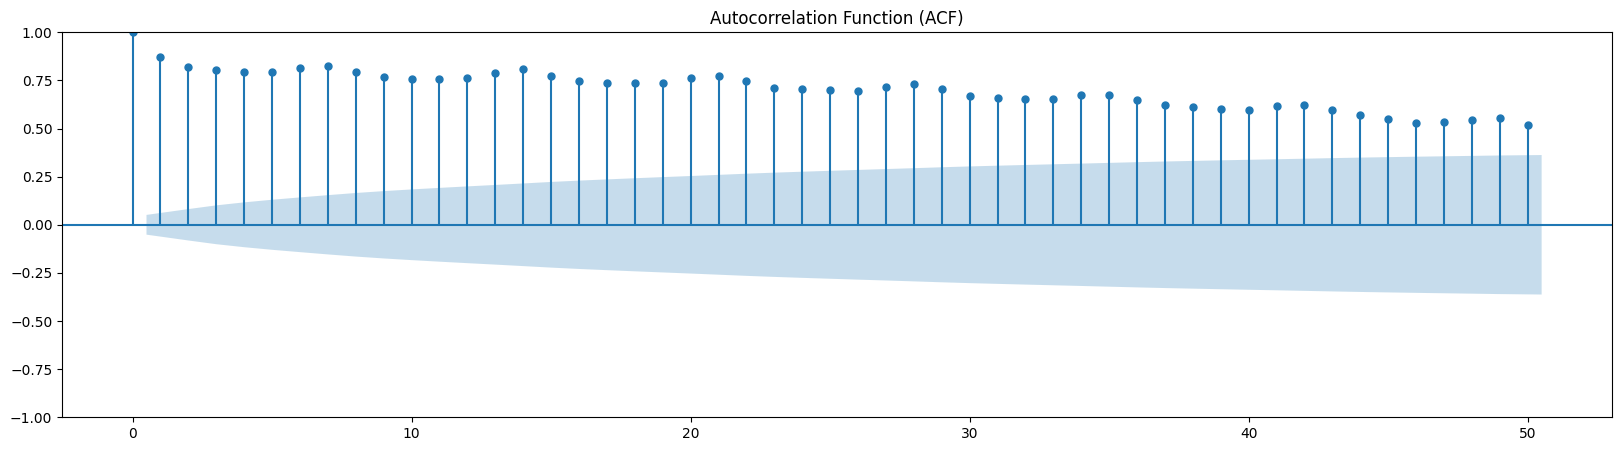

In [ ]:
# Create a figure with the desired figsize for ACF
fig_acf, ax_acf = plt.subplots(figsize=(20, 5))
plot_acf(rides_by_date['rides'], lags=50, ax=ax_acf, title='Autocorrelation Function (ACF)')
plt.show()

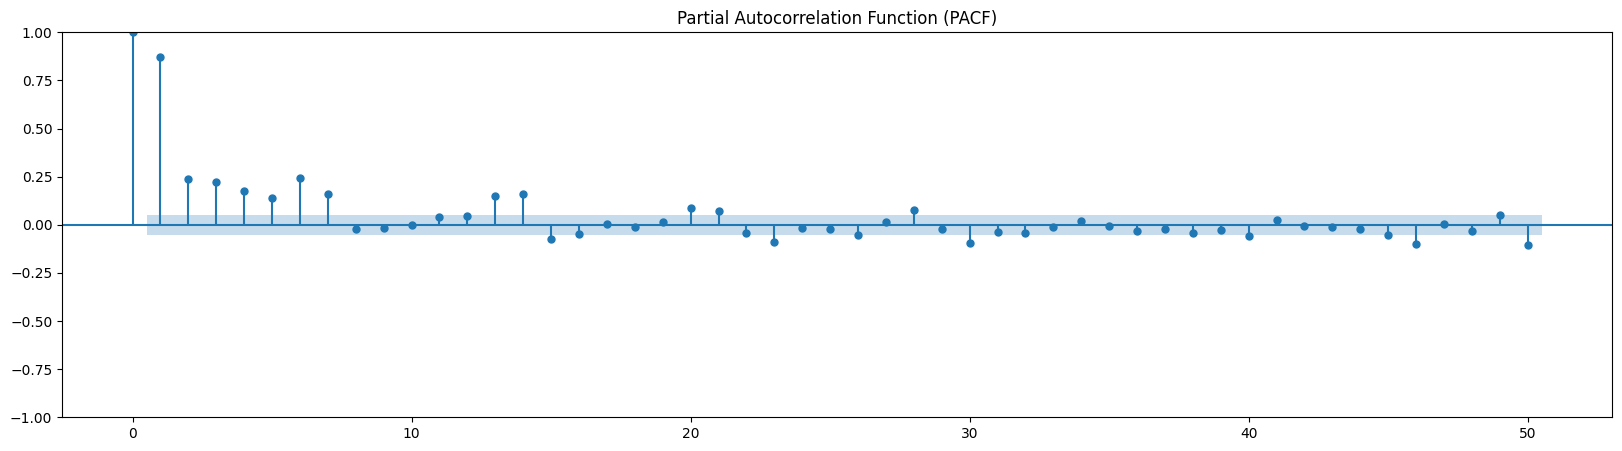

In [ ]:
# Create a figure with the desired figsize for ACF
fig_acf, ax_acf = plt.subplots(figsize=(20, 5))
plot_pacf(rides_by_date['rides'], lags=50, ax=ax_acf, title='Partial Autocorrelation Function (PACF)')
plt.show()

There's strong yearly seasonality and mild week seasonality.

# Stationarity

In [ ]:
def stationarity_tests(series, alpha, verbal=False):
    # Perform ADF test
    adf_result = adfuller(series, autolag='AIC')
    adf_test = {
        "Test Statistic": adf_result[0],
        "p-value": adf_result[1],
        "Lags Used": adf_result[2],
        "Number of Observations": adf_result[3],
        "Critical Values": adf_result[4],
        "Stationary": adf_result[1] < alpha
    }


    # Perform KPSS test
    kpss_result = kpss(series, regression='c', nlags='auto')
    kpss_test = {
        "Test Statistic": kpss_result[0],
        "p-value": kpss_result[1],
        "Lags Used": kpss_result[2],
        "Critical Values": kpss_result[3],
        "Stationary": kpss_result[1] > alpha
    }

    if verbal:
        print(adf_test)
        print(kpss_test)
    adf_out = ""
    kpss_out = ""
    res_out = ""
    if adf_test["Stationary"]:
        adf_out = "stationary"
        if kpss_test["Stationary"]:
            kpss_out = "stationary"
            res_out = "stationary"
        else:
            kpss_out = "non-stationary"
            res_out = "difference stationary"
    else:
        adf_out = "non-stationary"
        if kpss_test["Stationary"]:
            kpss_out = "stationary"
            res_out = "trend stationary"
        else:
            kpss_out = "non-stationary"
            res_out = "non-stationary"
    return {"ADF Result":adf_out, "KPSS Result": kpss_out, "Final Result":res_out }
print(stationarity_tests(rides_by_date["rides"],0.005))

{'ADF Result': 'non-stationary', 'KPSS Result': 'stationary', 'Final Result': 'trend stationary'}


Daily Differencing

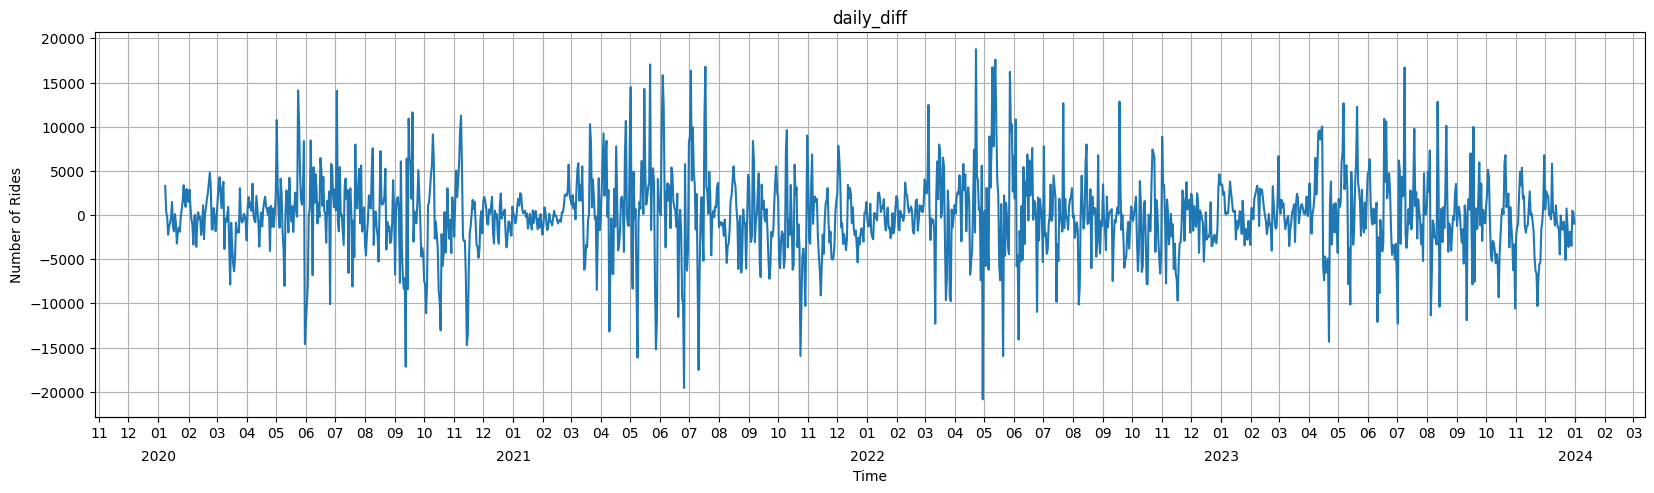

{'ADF Result': 'stationary', 'KPSS Result': 'stationary', 'Final Result': 'stationary'}


In [ ]:
rides_by_date["daily_diff"]=rides_by_date["rides"].diff(7)
plot_ts(rides_by_date['date'], rides_by_date["daily_diff"],"daily_diff")
print(stationarity_tests(rides_by_date["daily_diff"].dropna(),0.005))

Weekly Differencing

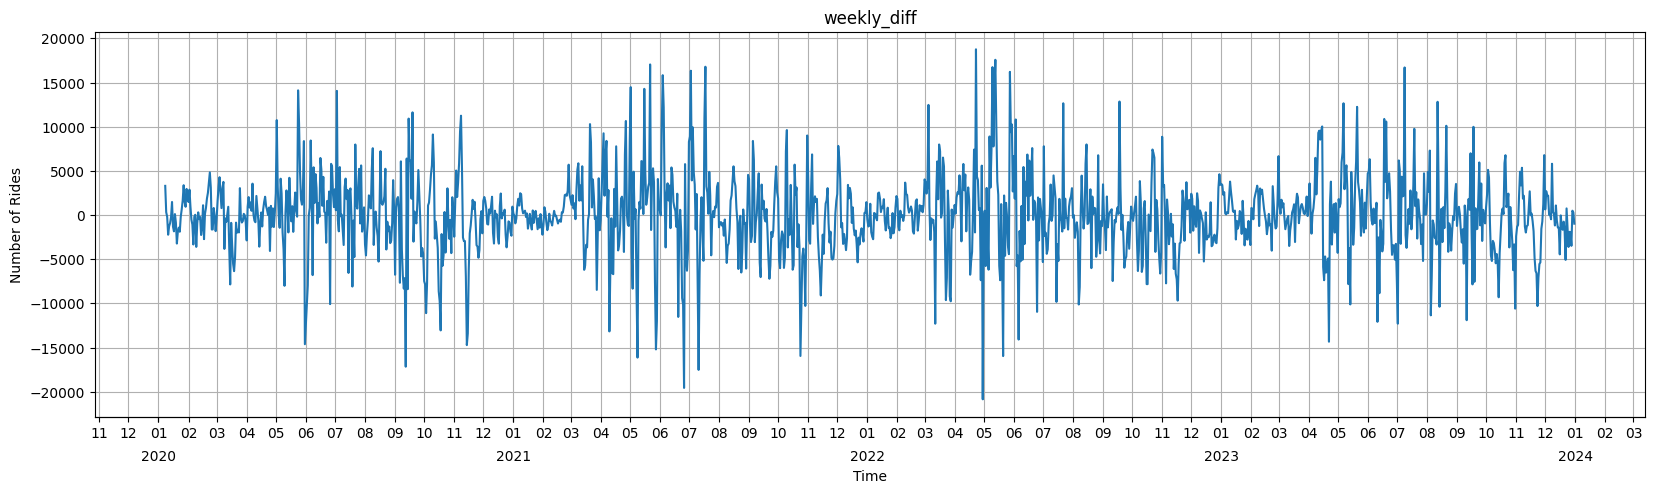

{'ADF Result': 'stationary', 'KPSS Result': 'stationary', 'Final Result': 'stationary'}


In [ ]:
rides_by_date["weekly_diff"]=rides_by_date["rides"].diff(7)
plot_ts(rides_by_date['date'], rides_by_date["weekly_diff"],"weekly_diff")
print(stationarity_tests(rides_by_date["weekly_diff"].dropna(),0.005))

Yearly Differencing

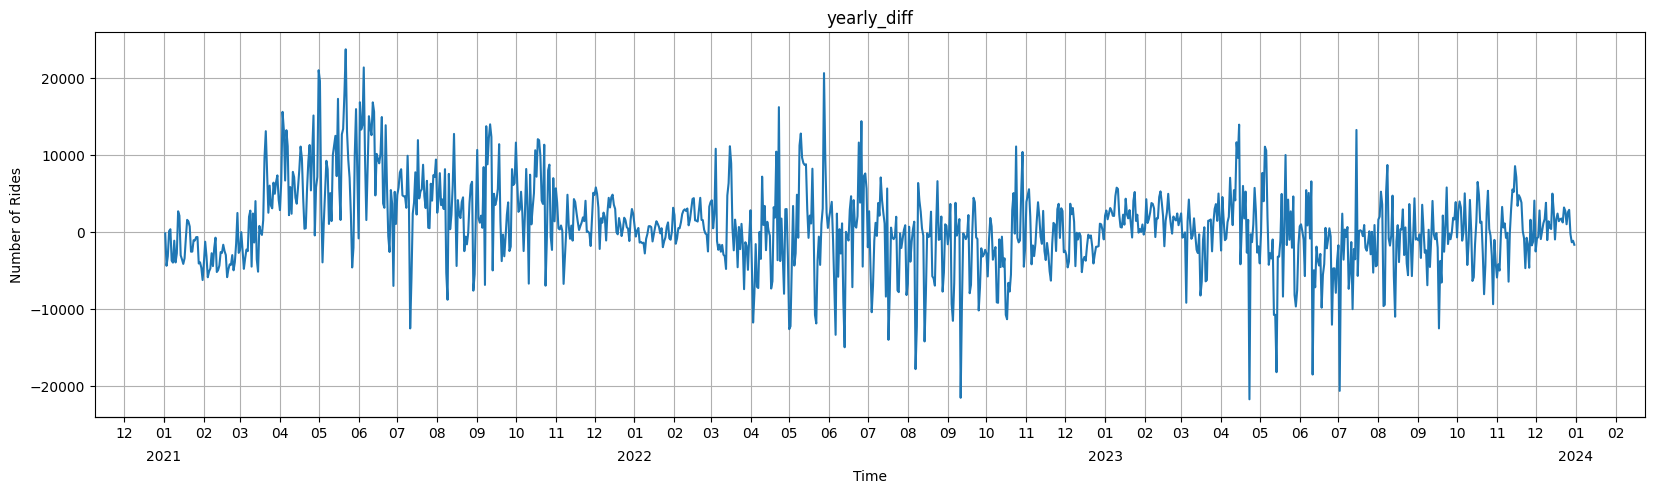

{'ADF Result': 'non-stationary', 'KPSS Result': 'stationary', 'Final Result': 'trend stationary'}


In [ ]:
rides_by_date["yearly_diff"]=rides_by_date["rides"].diff(365)
plot_ts(rides_by_date['date'], rides_by_date["yearly_diff"],"yearly_diff")
print(stationarity_tests(rides_by_date["yearly_diff"].dropna(),0.005))